In [1]:
import numpy as np   # numercal python. 수치 해석
import pandas as pd   # DataFrame을 쉽게 다루기

import matplotlib.pyplot as plt   # Data visualization
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 5
import seaborn as sns   # Data visualization
sns.set(font_scale = 2.0)   # seaborn 라이브러리 세팅 (plot의 모든 폰트 사이즈를 2.0로 지정)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')   # ignore warning

# __1. DataFrame Preprocessing__

In [2]:
ts = pd.read_csv('05_MG9_ts.csv', index_col='Date')
ts.index = pd.to_datetime(ts.index)
ts

,Marine Gasoil 9_Price
Date,
2022-01-04,775.5
2022-01-05,800.5
2022-01-06,802.5
2022-01-07,806.5
2022-01-10,813.5
...,...
2024-04-16,876.5
2024-04-17,865.5
2024-04-18,859.5


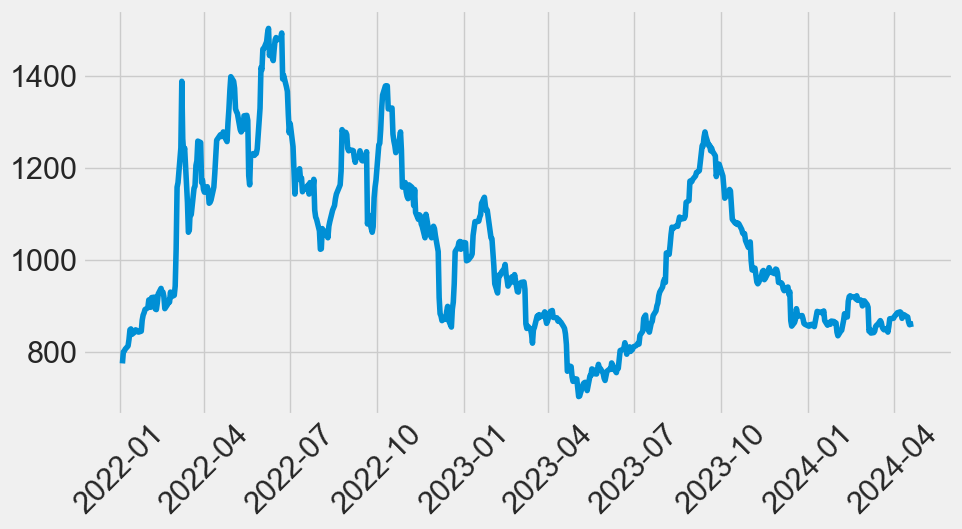

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5
plt.xticks(rotation=45)
plt.plot(ts);

# __2. Data Splitting__

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, period=10)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

In [5]:
last_date = ts.index.max()

test_start_date = last_date - pd.Timedelta(days=14)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)

train_val = ts.loc[ts.index <= test_start_date]
test = ts.loc[ts.index > test_start_date]

train_val.shape, test.shape

((585, 1), (10, 1))

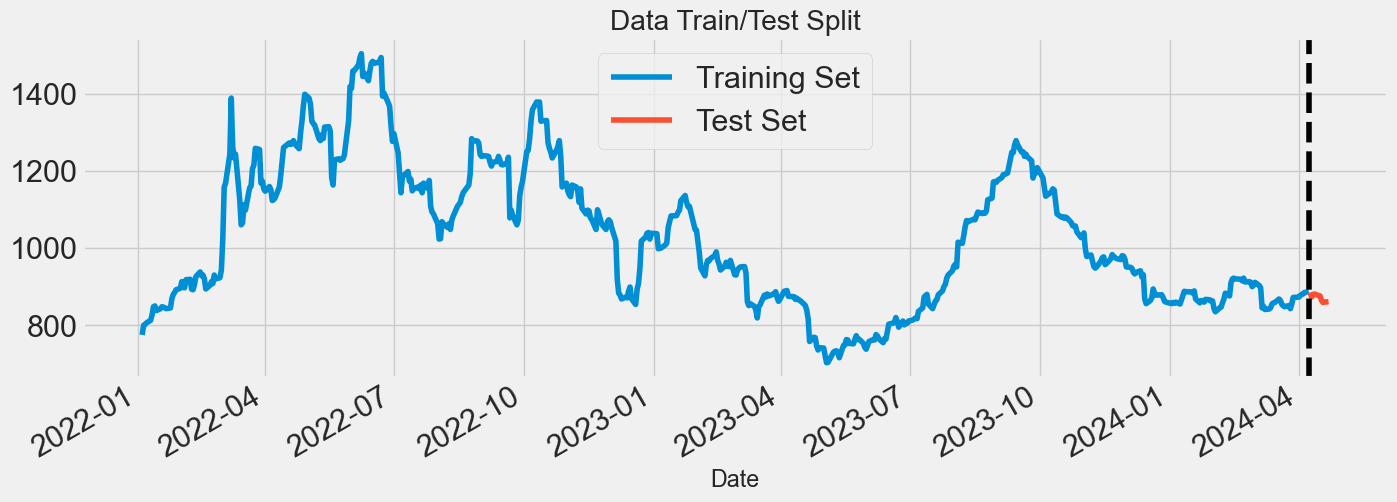

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
train_val.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(test_start_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

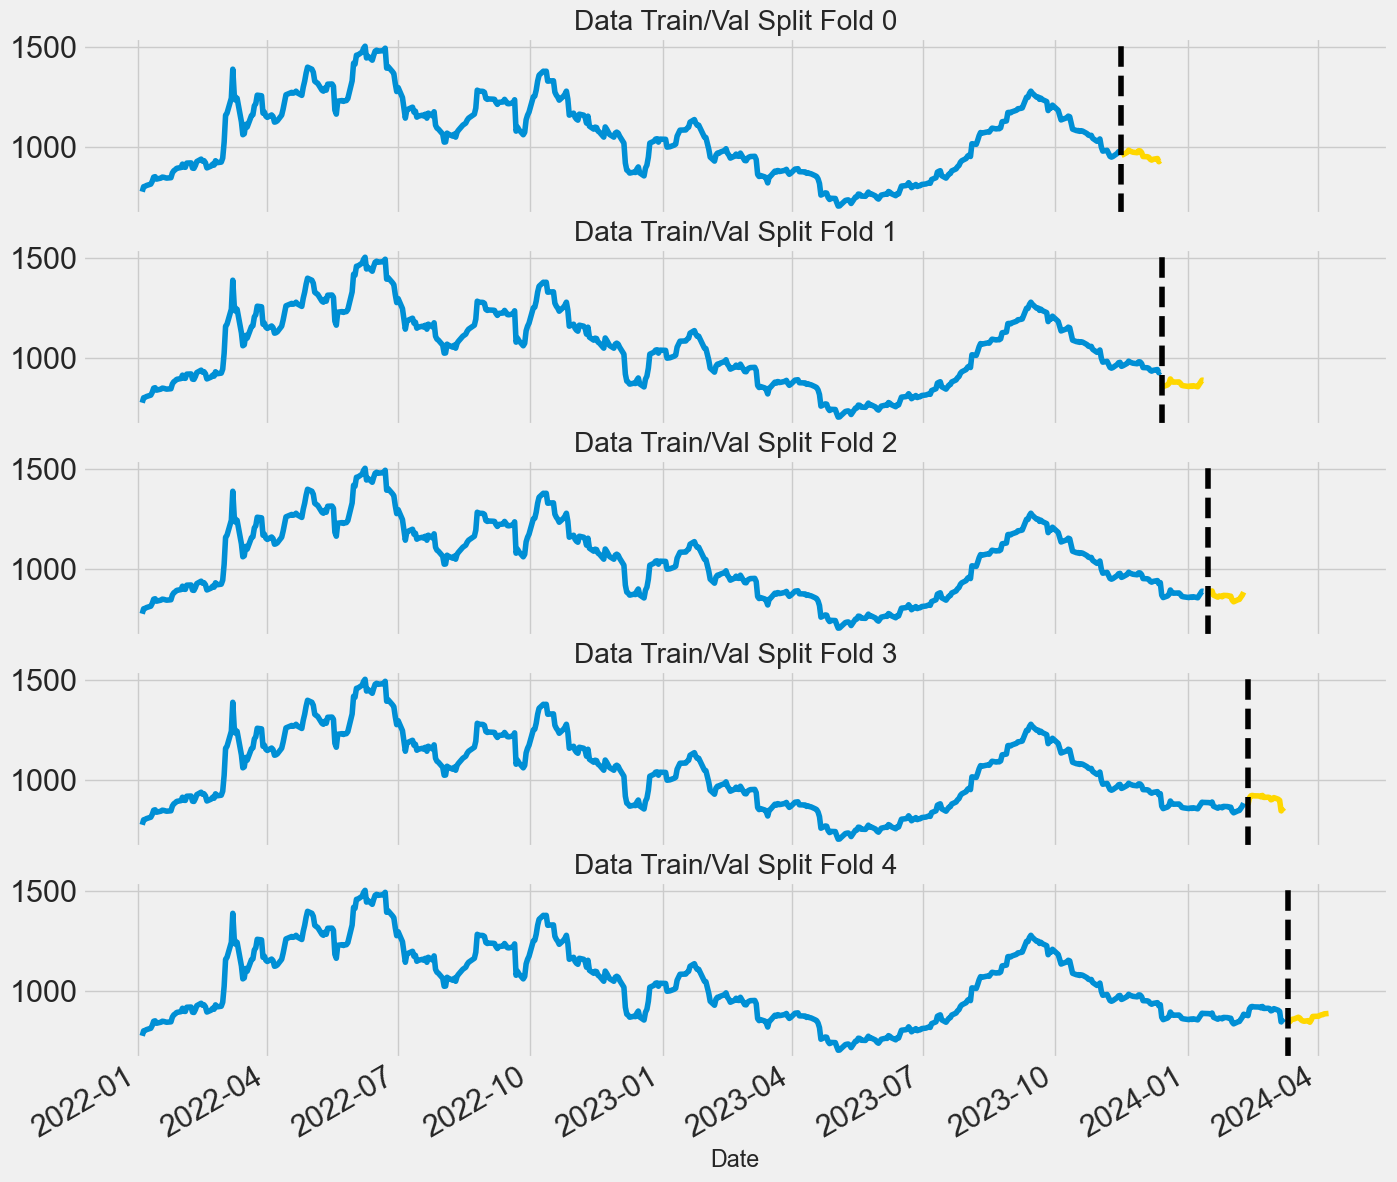

In [7]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 5, test_size=20)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(train_val):
    train = train_val.iloc[train_idx]
    validation = train_val.iloc[val_idx]
    train['Marine Gasoil 9_Price'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Val Split Fold {fold}')
    validation['Marine Gasoil 9_Price'].plot(ax=axs[fold], label='Test Set', color='gold')
    axs[fold].axvline(validation.index.min(), color='black', ls='--')
    fold += 1

plt.show()

# __3. Feature Engineering__

## __3.1 Trend, Seasonal__

In [8]:
train_val['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
train_val['seasonal'] = seasonal

test['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
test['seasonal'] = seasonal

## __3.2. Simple Rolling Mean Average__

In [9]:
# 이동평균을 추가하는 함수
def add_rolling_mean(df:pd.DataFrame, col_name:str, window_list:list)->pd.DataFrame:
    for window in window_list:
        df[col_name + f'_rolling{window}'] = df[col_name].rolling(window).mean().fillna(method='bfill')
    return df

In [10]:
# 예측하고자 하는 기준이 짧으므로, 단기(5일(1주)) 및 장기 (10일(2주), 20일(1개월), 60일(3개월), 120일(6개월), 240일(1년)) 이동평균 추가
train_val = add_rolling_mean(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])
test = add_rolling_mean(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])

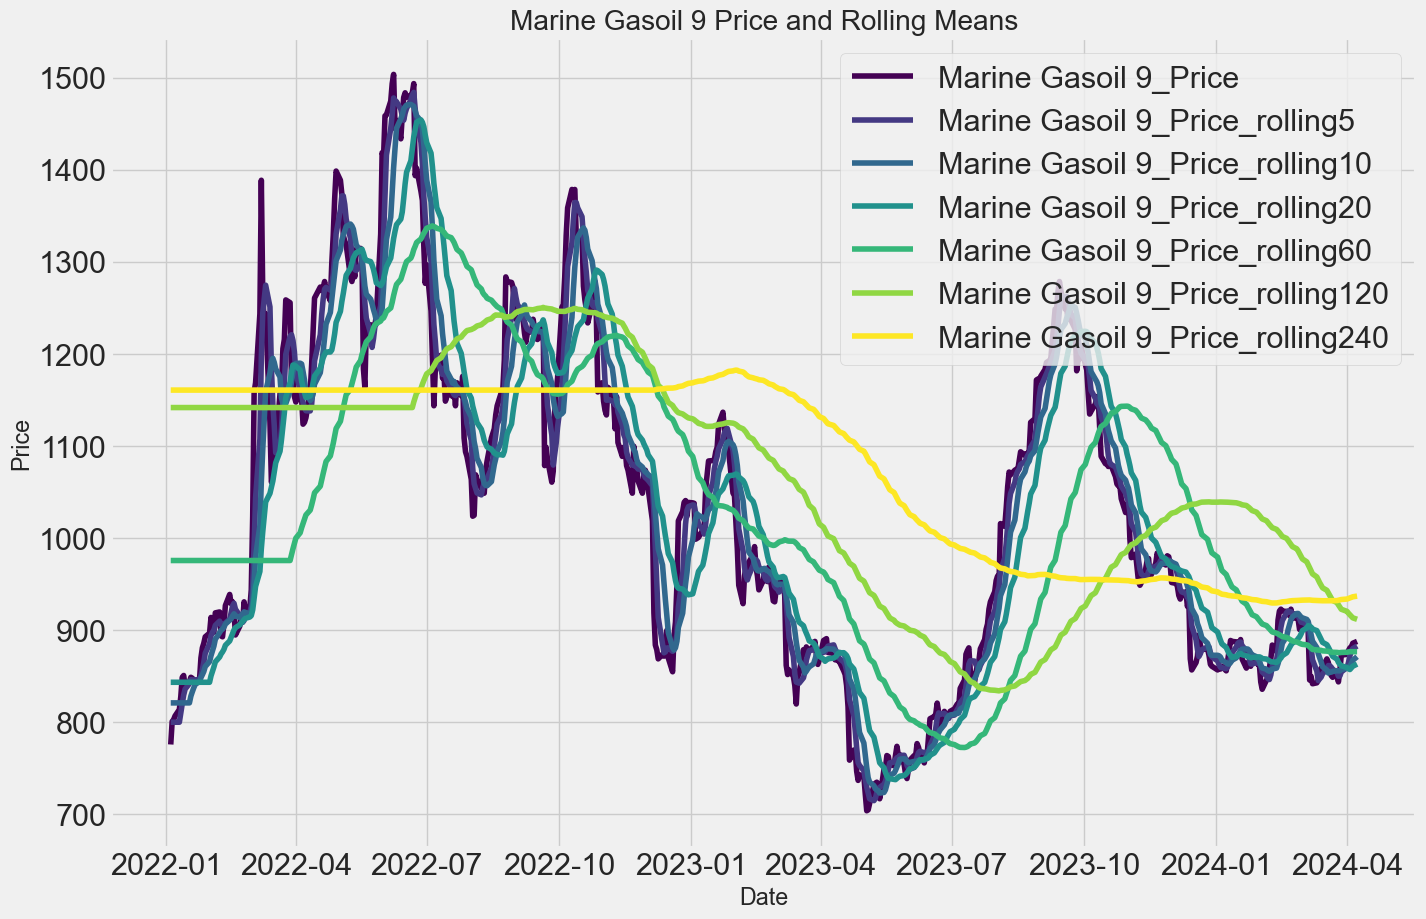

In [11]:
columns_to_plot = [
    'Marine Gasoil 9_Price',
    'Marine Gasoil 9_Price_rolling5',
    'Marine Gasoil 9_Price_rolling10',
    'Marine Gasoil 9_Price_rolling20',
    'Marine Gasoil 9_Price_rolling60',
    'Marine Gasoil 9_Price_rolling120',
    'Marine Gasoil 9_Price_rolling240'
]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## __3.3 Lag Feature__ 

In [13]:
def add_lags(df: pd.DataFrame, col_name: str, lag_days_list: list) -> pd.DataFrame:
    target_map = df[col_name].to_dict()
    for days in lag_days_list:
        df[f'{col_name}_lag{days}'] = (df.index - pd.Timedelta(days=days)).map(target_map)
    df = df.fillna(method='bfill').fillna(method='ffill')
    return df

In [14]:
train_val = add_lags(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])
test = add_lags(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])

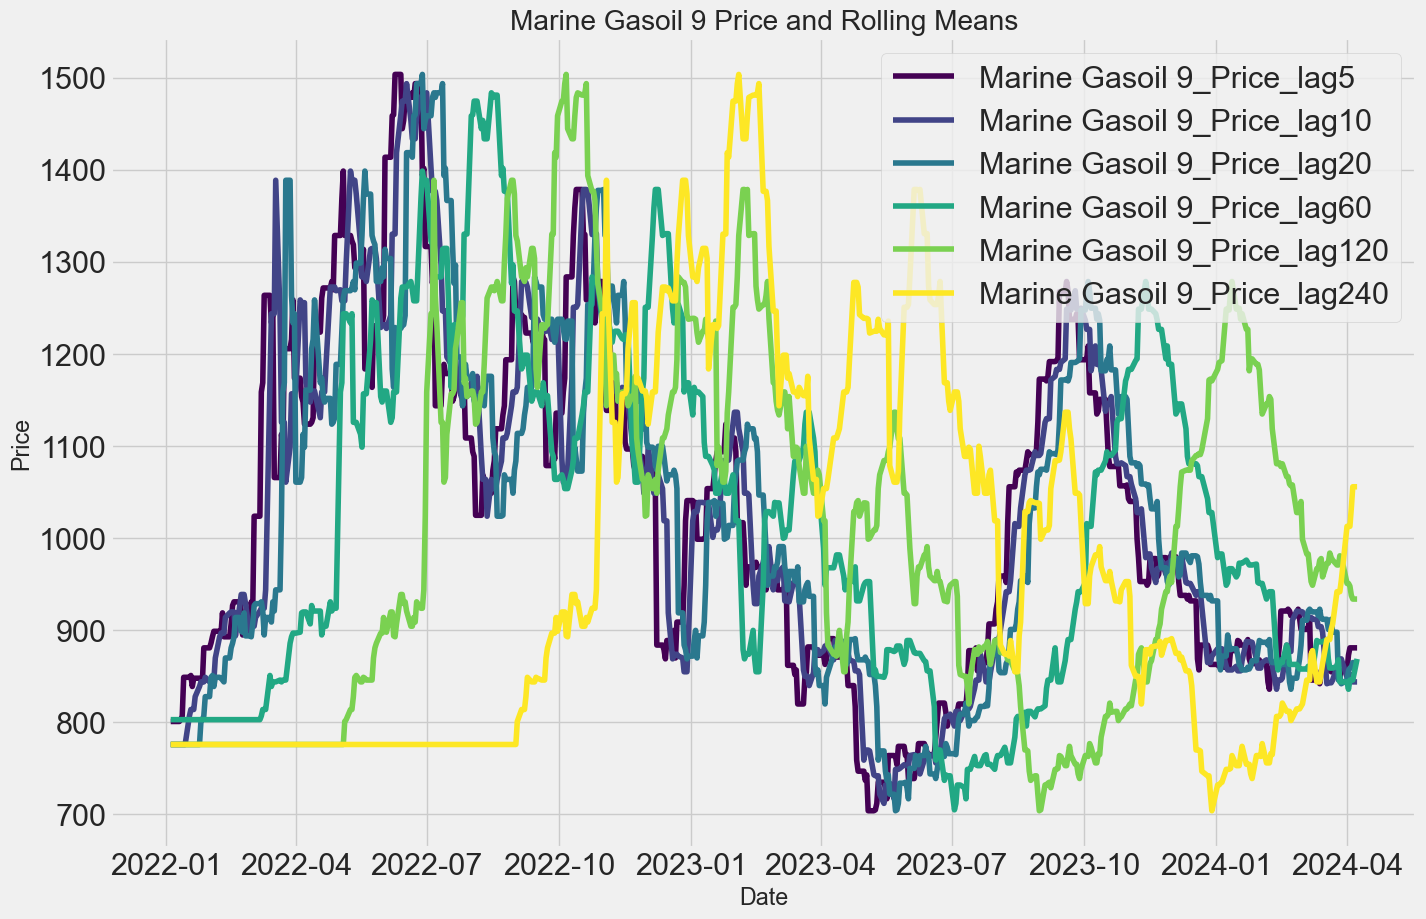

In [15]:
columns_to_plot = [
    'Marine Gasoil 9_Price_lag5',
    'Marine Gasoil 9_Price_lag10',
    'Marine Gasoil 9_Price_lag20',
    'Marine Gasoil 9_Price_lag60',
    'Marine Gasoil 9_Price_lag120',
    'Marine Gasoil 9_Price_lag240'
    ]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## __3.4 Dummies__

In [16]:
train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

In [17]:
train_val

,Marine Gasoil 9_Price,trend,seasonal,Marine Gasoil 9_Price_rolling5,Marine Gasoil 9_Price_rolling10,Marine Gasoil 9_Price_rolling20,Marine Gasoil 9_Price_rolling60,Marine Gasoil 9_Price_rolling120,Marine Gasoil 9_Price_rolling240,Marine Gasoil 9_Price_lag5,...,Marine Gasoil 9_Price_lag60,Marine Gasoil 9_Price_lag120,Marine Gasoil 9_Price_lag240,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,775.5,824.35,-5.231626,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,802.5,775.5,775.5,2022,1,1,1,4,1,4
2022-01-05,800.5,824.35,-3.915246,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,802.5,775.5,775.5,2022,1,1,2,5,1,5
2022-01-06,802.5,824.35,-0.995419,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,802.5,775.5,775.5,2022,1,1,3,6,1,6
2022-01-07,806.5,824.35,2.860041,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,802.5,775.5,775.5,2022,1,1,4,7,1,7
2022-01-10,813.5,824.35,6.379868,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,802.5,775.5,775.5,2022,1,1,0,10,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-02,877.5,872.60,-5.231626,864.5,859.2,857.80,876.083333,918.108333,934.102083,872.5,...,835.5,950.5,1012.5,2024,2,4,1,2,14,93
2024-04-03,880.5,875.80,-3.915246,871.9,860.8,856.95,876.316667,916.375000,934.677083,880.5,...,845.5,947.5,1012.5,2024,2,4,2,3,14,94
2024-04-04,881.5,878.45,-0.995419,877.1,863.5,858.75,876.383333,914.716667,935.260417,880.5,...,845.5,937.5,1032.5,2024,2,4,3,4,14,95


# __4.Cross Validation__

In [18]:
validation_start_date = test_start_date - pd.Timedelta(days=30)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((565, 22), (20, 22), (10, 22))

In [19]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [20]:
cat_model = CatBoostRegressor(iterations=10000,
                              learning_rate=0.01,
                              depth=6,
                              l2_leaf_reg=1,
                              eval_metric='RMSE',
                              random_seed=42,
                              bagging_temperature=0.8,
                              od_type='Iter',
                              od_wait=50)

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']
tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    cat_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = cat_model.predict(X_train)
    y_val_pred = cat_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

0:	learn: 184.1503557	test: 200.0737373	best: 200.0737373 (0)	total: 151ms	remaining: 25m 10s
100:	learn: 85.0123542	test: 135.7564447	best: 135.7564447 (100)	total: 396ms	remaining: 38.8s
200:	learn: 46.4439097	test: 112.2626818	best: 112.2626818 (200)	total: 655ms	remaining: 31.9s
300:	learn: 30.3419022	test: 103.2884951	best: 103.2884951 (300)	total: 948ms	remaining: 30.6s
400:	learn: 22.4219044	test: 99.4923241	best: 99.4923241 (400)	total: 1.3s	remaining: 31.1s
500:	learn: 17.3969187	test: 97.2978122	best: 97.2950464 (499)	total: 1.68s	remaining: 31.8s
600:	learn: 13.8365962	test: 96.7192457	best: 96.7015918 (592)	total: 2.03s	remaining: 31.7s
700:	learn: 11.4023863	test: 96.6027650	best: 96.5145355 (671)	total: 2.34s	remaining: 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 96.44390772
bestIteration = 732

Shrink model to first 733 iterations.
0:	learn: 177.0759516	test: 153.5501628	best: 153.5501628 (0)	total: 3.9ms	remaining: 39s
100:	learn: 83.8145090	te

In [22]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [68.22155457266767, 70.58889276776783, 101.82444808509025, 28.794263425649202, 18.144695419376045]
Average MAE across folds: 57.51
RMSE for each fold: [96.44390772286168, 96.61316945250687, 114.10960459240765, 37.433153233929026, 23.722138566403153]
Average RMSE across folds: 73.66
MAPE for each fold: [5.203927268766841, 7.168706606392003, 13.052239851619063, 2.6410291295444206, 2.075077239845457]
Average MAPE across folds: 6.03


# __5. CatBoost__

In [23]:
# 최종 모델 학습
cat_model.fit(X_train, y_train,
              eval_set = [(X_val, y_val)],
              verbose=100)

0:	learn: 186.8786597	test: 167.9133429	best: 167.9133429 (0)	total: 7.79ms	remaining: 1m 17s
100:	learn: 84.2995283	test: 78.1506886	best: 78.1506886 (100)	total: 403ms	remaining: 39.4s
200:	learn: 45.2229938	test: 44.8299381	best: 44.8299381 (200)	total: 890ms	remaining: 43.4s
300:	learn: 31.0282755	test: 32.7436216	best: 32.7436216 (300)	total: 1.4s	remaining: 45.3s
400:	learn: 25.0929969	test: 29.2901863	best: 29.2467143 (398)	total: 1.94s	remaining: 46.5s
500:	learn: 21.9496634	test: 28.3745944	best: 28.3577380 (493)	total: 2.6s	remaining: 49.2s
600:	learn: 19.7086223	test: 27.9902240	best: 27.9681902 (590)	total: 3.08s	remaining: 48.2s
700:	learn: 17.9791933	test: 27.5956138	best: 27.5956138 (700)	total: 3.58s	remaining: 47.6s
800:	learn: 16.5060233	test: 27.2808345	best: 27.2745946 (792)	total: 4.08s	remaining: 46.9s
900:	learn: 15.2929617	test: 26.9133253	best: 26.8939704 (893)	total: 4.69s	remaining: 47.4s
1000:	learn: 14.2406642	test: 26.7240565	best: 26.7240565 (1000)	total:

In [24]:
pred_val = cat_model.predict(X_val)
pred_test = cat_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_cv'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_cv'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

,Marine Gasoil 9_Price,prediction_xgb_val_cv,prediction_xgb_cv
Date,,,
2022-01-04,775.5,NaN,NaN
2022-01-05,800.5,NaN,NaN
2022-01-06,802.5,NaN,NaN
2022-01-07,806.5,NaN,NaN
2022-01-10,813.5,NaN,NaN
...,...,...,...
2024-04-16,876.5,NaN,882.952039
2024-04-17,865.5,NaN,885.634039
2024-04-18,859.5,NaN,878.331273


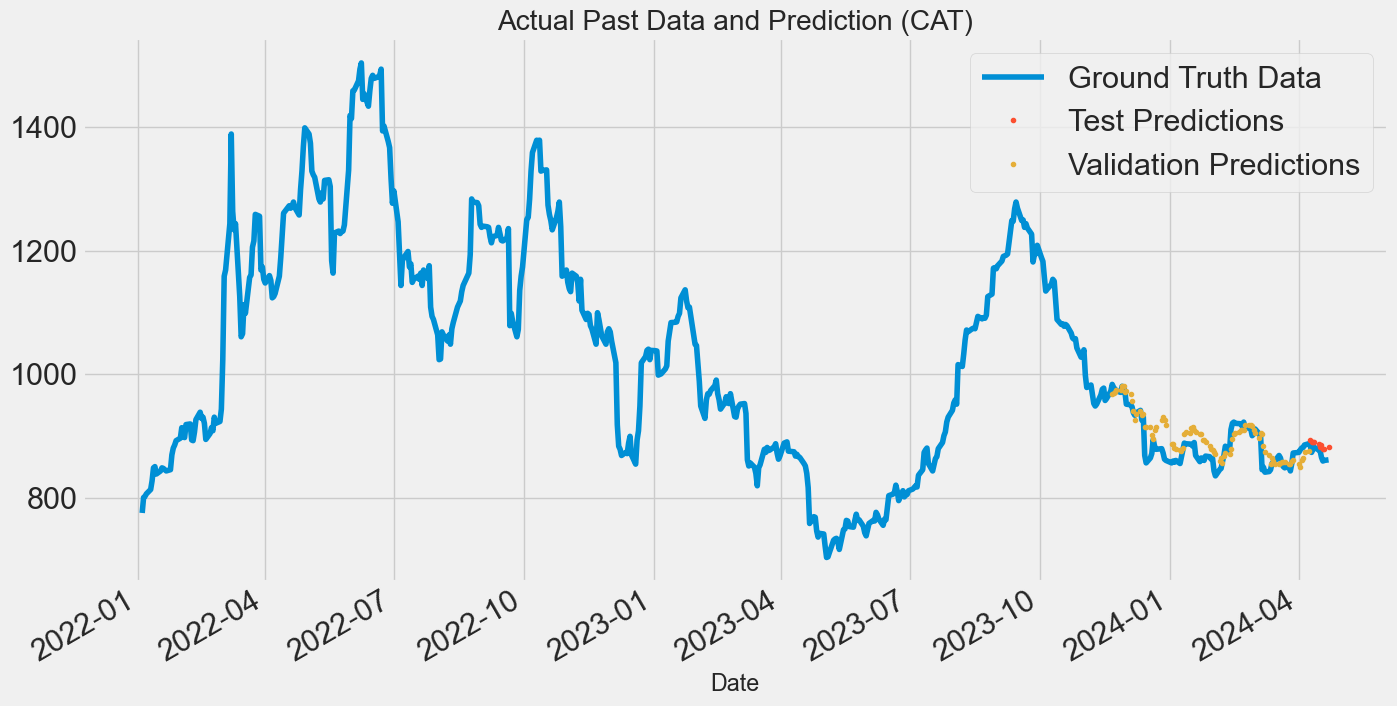

In [27]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_cv'].plot(ax=ax, style='.')
ts['prediction_xgb_val_cv'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (CAT)')
plt.show();

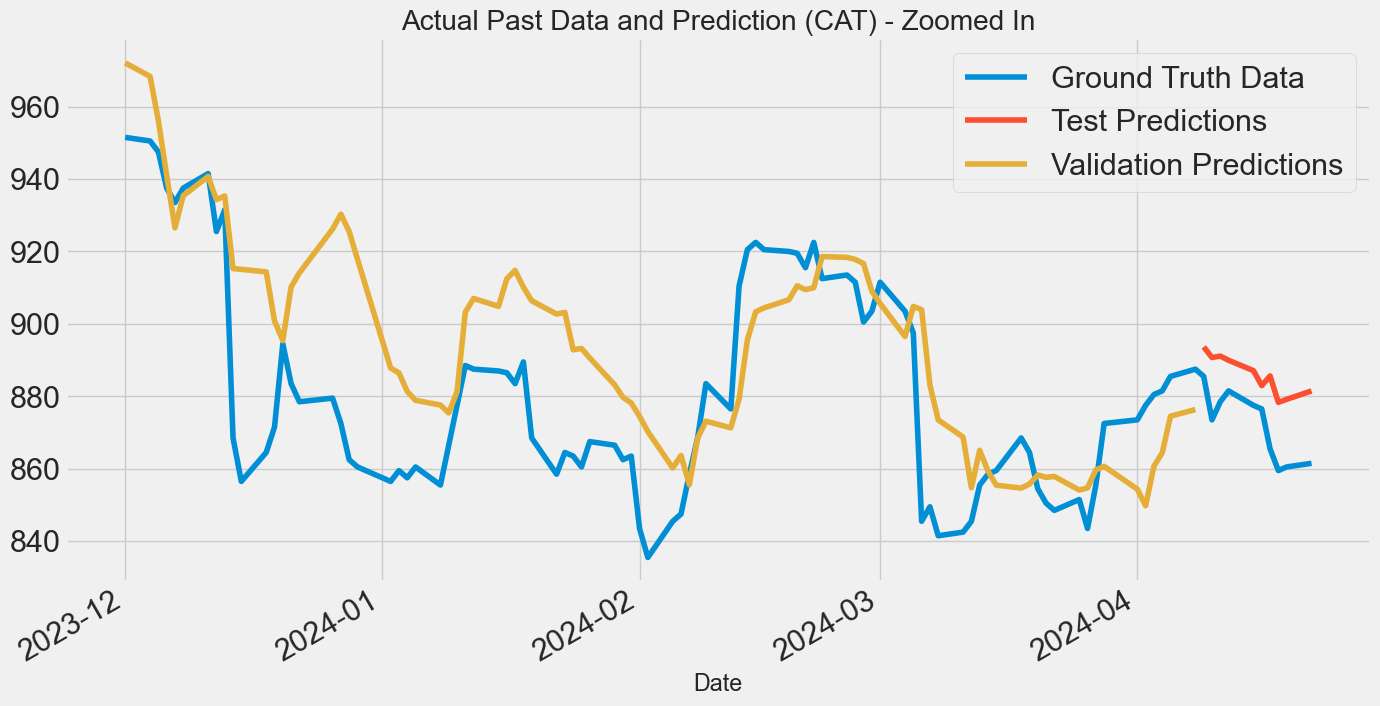

In [28]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-12-01'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_xgb_cv'].plot(ax=ax, style='-')
ts_zoomed['prediction_xgb_val_cv'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (CAT) - Zoomed In')
plt.show()

## __5.1 Performance__

In [1]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_xgb_val_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv']))
score_mape_xgb_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv'])

# 결과 출력
print(f'MAE Score on Validation set (CAT): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (CAT): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (CAT): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

NameError: name 'ts' is not defined

In [30]:
ts_clean = ts.dropna(subset=['prediction_xgb_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv']))
score_mape_xgb = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv'])

# 결과 출력
print(f'MAE Score on Validation set (CAT): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Validation set (CAT): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Validation set (CAT): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 14.01
RMSE Score on Validation set (XGB): 14.95
MAPE Score on Validation set (XGB): 1.61%


## __5.2. SHAP__

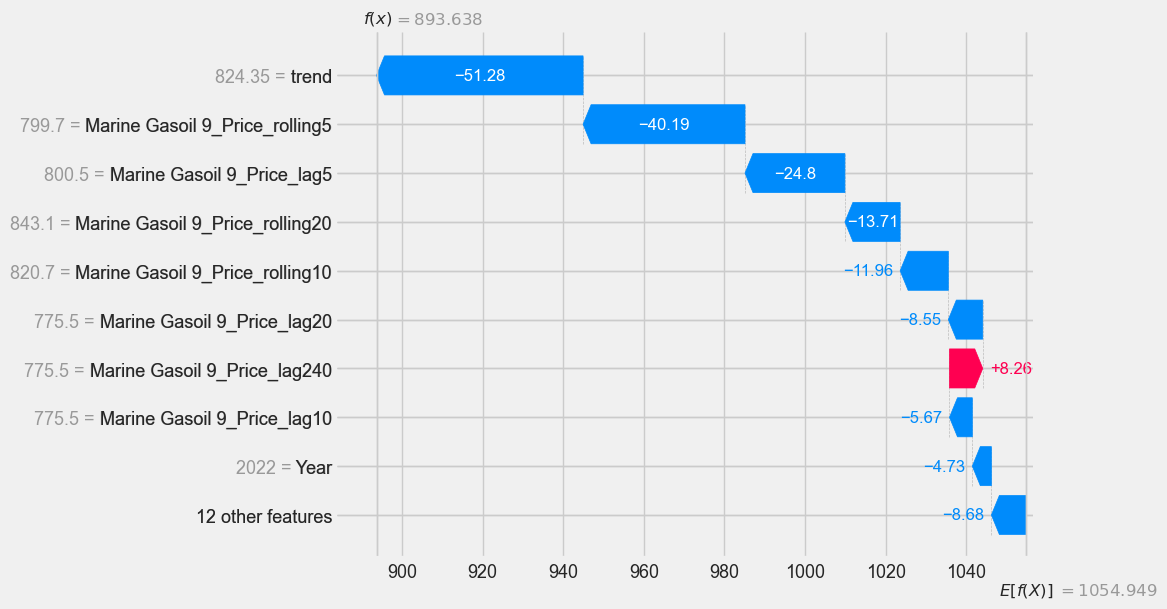

In [32]:
import shap

xgb_explainer = shap.Explainer(cat_model)
shap_values_xgb = xgb_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb[0],
                                     base_values=xgb_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))

# __6. Hyperparameter Tuning__

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=100
)

In [34]:
# 데이터 준비
X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']

# GridSearch 실행
grid_search.fit(X_train_val, y_train_val)

# 결과 출력
print("Best parameters:", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

KeyError: "['Date'] not found in axis"